## *Import Libraries*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings("ignore")

## *Load Dataset*

In [3]:
df = pd.read_csv("cars_sales_ohe.csv")

In [4]:
X = df.drop(columns=['price'])
y = df.price

## *Split Data*

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

### *Array Transform*

In [8]:
def array(x):
    return np.asarray(x)

In [9]:
X_train,Y_train = array(X_train),array(Y_train)
X_test,Y_test = array(X_test),array(Y_test)

We create numpy arrays, as it will speed up the model training process.

In [10]:
X_train.shape,X_test.shape

((69186, 175), (17297, 175))

## *Model Creation*

In [11]:
from xgboost import XGBRegressor

In [12]:
xgb = XGBRegressor(max_depth = 10,
                   n_estimators = 800,
                   learning_rate = 0.01,
                   colsample_bytree = 0.7,
                   subsample = 0.7,
                   colsample_bynode = 0.8,
                   reg_alpha = 0.5,
                   gamma = 20,
                    n_jobs = -1)

In [13]:
xgb.fit(X_train,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.8, colsample_bytree=0.7,
             enable_categorical=False, gamma=20, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=800, n_jobs=-1, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1,
             subsample=0.7, tree_method='exact', validate_parameters=1,
             verbosity=None)

## *Evaluation*

#### *Mean Squared Error*

It is the average error between the predictions generated from the model and the original values.

In [14]:
from sklearn.metrics import mean_squared_error

In [15]:
def MSE(model):
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    mse_train = mean_squared_error(Y_train,pred_train)
    mse_test = mean_squared_error(Y_test,pred_test)
    
    
    return mse_train,mse_test

In [16]:
mse_train,mse_test = MSE(xgb)

In [17]:
print(f"MSE Train: {mse_train}")
print(f"MSE Test:  {mse_test}")

MSE Train: 3426481.8800247484
MSE Test:  3820895.5054136794


Thanks to hyperparameter tuning, it lowers the MSE for the test data, which is quite a positive effect.

#### *Determination Coefficient*
In statistics, the coefficient of determination, called R²,it consists of seeing the degree of covariance explained by the model, the closer the R², the greater the closeness to the original values. 

In [18]:
print(f"R*2 Train: {xgb.score(X_train,Y_train)}")
print(f"R*2 Test:  {xgb.score(X_test,Y_test)}")

R*2 Train: 0.9554883336390929
R*2 Test:  0.950608607937317


### *Cross Validation*

It consists of evaluating a subsampling of the data set determined by the user, it serves to have a better idea of the percentage of generalization of the model.

In [19]:
from sklearn.model_selection import cross_val_score

In [20]:
cv = cross_val_score(xgb,X_test,Y_test,cv = 10,n_jobs = -1)

In [21]:
cv

array([0.92197   , 0.9234041 , 0.94053414, 0.94236197, 0.93875546,
       0.92897888, 0.94274282, 0.94625074, 0.94718143, 0.92974187])

In general, it has good explanatory power for each of the 10 random subsamples.

In [22]:
cv.mean()

0.936192140400507

It offers a generalization percentage of 94%, which is quite a high percentage, which means that the model is able to describe a high percentage of the data.

In [23]:
sns.set_style(style = "whitegrid")

In [24]:
pred = xgb.predict(X_test)

In [25]:
def main():
    
    fig = plt.subplots(1,1,figsize = (20,8))
    plt.scatter(Y_test,pred,marker = "+",c= "#adff2f",alpha = 0.4,label = "Predictions")
    plt.plot(Y_test,Y_test,c = "#4000ff",lw = 5,label = "True Values")
    plt.legend()

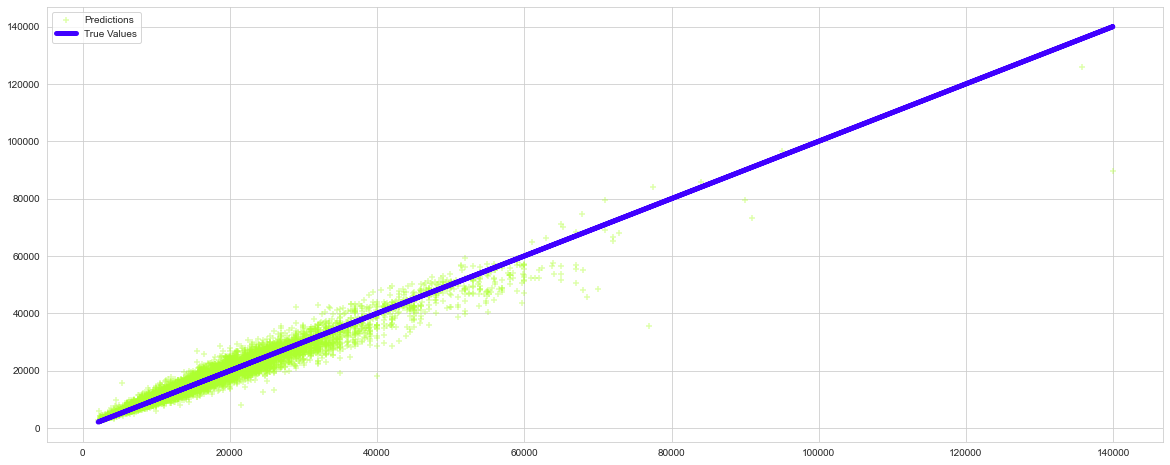

In [26]:
_ = main()

In [27]:
df_predictions = pd.DataFrame({'True Values':Y_test,"Predictions":pred})

In [28]:
df_predictions.sample(n = 10,random_state = 50)

,True Values,Predictions
16104,25500,27827.382812
4453,7500,7229.646484
7060,15490,16779.384766
10216,11490,11269.562500
603,16557,14838.195312
486,17520,16443.957031
2185,18999,19118.751953
16000,17500,16971.375000
15545,6710,7755.176758
4635,10200,9547.789062


As seen in the graph and in the model metrics, the predictions are very close to the original value.

Due to the excessive number of predictor variables, I opted to create a function in order to extract the most relevant variables determined by the model.

* If the vehicle has a Manual transmission, the price of the vehicle generally decreases, it is less expensive with an automatic or semi-automatic transmission.



* The engine size is a variable that has a lot of weight. Since the greater the capacity, the greater the technical capacity of the car.



* The year of manufacture includes in the price, since if a vehicle of the same model. It will make the price of the car more expensive, since it will be a more recent model.






* Other variables that complement the predictions well is the vehicle brand, since for example it is well known that Mercedes-benz vehicles belong to high-end manufacturers, which means that the price per car is much higher. Also the number of miles traveled, since generally a vehicle with higher mileage has more wear, which causes a devaluation of the car.

## New Predictions

In [37]:
columns = X.columns

In [38]:
for index,column in enumerate(columns):
   if column == 'year' or column == 'engineSize' or column == 'mileage':
    print(index,column)

168 year
173 engineSize
174 mileage


With the enumerate function, the indices of each object are obtained, in this case of each variable of interest, it will help us to know the exact index number for these variables that do not require OHE.

In [54]:
def predict(manufacturer,model,transmission,year,fuel_type,engineSize,mileage):
    
    data = np.zeros(len(columns))
    
    manufacturer_idx = np.where(columns == manufacturer)[0][0]
    model_idx = np.where(columns == model)[0][0]
    transmission_idx = np.where(columns == transmission)[0][0]
    fuel_type_idx = np.where(columns == fuel_type)[0][0]
    
    data[165] = year
    data[170] = engineSize
    data[171] = mileage

    
    if manufacturer_idx >=0:
        data[manufacturer_idx] = 1

    if model_idx >=0:
        data[model_idx] = 1
        
    if transmission_idx >=0:
        data[transmission_idx] = 1
        
    if fuel_type_idx >=0:
        data[fuel_type_idx] = 1
        
    data = np.asarray([data])
    pred = xgb.predict(data)
    
    return np.round(pred,2)

In [55]:
predict('Ford','Mustang','Automatic',2020,'Petrol',5.0,3500)

array([10768.69], dtype=float32)

In [56]:
predict('Toyota','Corolla','Automatic',2019,'Hybrid',2.0,18200)

array([9991.47], dtype=float32)

In [57]:
predict('Volkswagen','Jetta','Automatic',2012,'Petrol',2.0,45000)

array([10813.27], dtype=float32)

In [58]:
predict('Audi','R8','Semi-Auto',2020,'Diesel',5.2,4200)

array([24786.33], dtype=float32)

In [44]:
predict('Ford','Fiesta','Automatic',2017,'Petrol',1.0,15944)

array([9550.1], dtype=float32)

In [45]:
predict('BMW','3 Series','Manual',2017,'Diesel',2.0,91000)

array([13094.3], dtype=float32)

In [46]:
predict('Hyundi','Santa Fe','Automatic',2014,'Diesel',2.2,45000)

array([10905.26], dtype=float32)

In [47]:
predict('Mercedes-Benz','C Class','Automatic',2019,'Petrol',1.5,15000)

array([14056.39], dtype=float32)

In [48]:
predict('Skoda','Octavia','Manual',2017,'Petrol',1.4,32000)

array([9458.4], dtype=float32)

In [49]:
predict('BMW','3 Series','Manual',2017,'Diesel',2.0,91000)

array([13094.3], dtype=float32)

In [50]:
predict('Vauxhall','Corsa','Manual',2018,'Petrol',1.4,17000)

array([7932.68], dtype=float32)